In [1]:
from typing import List
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tqdm import tqdm
import time

from chinese_checkers.reinforcement.experience import ExperienceData, ExperienceCatalog, ExperienceMetadata
from chinese_checkers.reinforcement.dql import DQLAgent, DqlModelValidation
import torch
import logging
from src.chinese_checkers.simulation.GameSimulation import GameSimulation
from src.chinese_checkers.model.BootstrapModel import BootstrapModel
from src.chinese_checkers.reinforcement.dql.DqlModel import DqlModel

# DQL Module Examples

---

## Example 1: Train the model on encoded experience data


### 1. Load the simulation datasets from the Simulation catalog

In [2]:
catalog = ExperienceCatalog()
dataset_metadata: List[ExperienceMetadata] = catalog.list_datasets()
dataset_metadata

[ExperienceMetadata(player_count='2', board_size='4', max_game_length='1000', winning_player='0', name='bootstrap-simulation', version='v0.0.1', generator_name='v0.0.1', current_player='3'),
 ExperienceMetadata(player_count='2', board_size='4', max_game_length='1000', winning_player='0', name='bootstrap-simulation', version='v0.0.1', generator_name='v0.0.2', current_player='0'),
 ExperienceMetadata(player_count='2', board_size='4', max_game_length='1000', winning_player='0', name='bootstrap-simulation', version='v0.0.1', generator_name='v0.0.2', current_player='3'),
 ExperienceMetadata(player_count='2', board_size='4', max_game_length='1000', winning_player='3', name='bootstrap-simulation', version='v0.0.1', generator_name='v0.0.1', current_player='0'),
 ExperienceMetadata(player_count='2', board_size='4', max_game_length='1000', winning_player='3', name='bootstrap-simulation', version='v0.0.1', generator_name='v0.0.1', current_player='3'),
 ExperienceMetadata(player_count='2', board_s

In [3]:

winning_players = ["0", "3"]
player_count = 2
current_player = "0"

# Start timer
start_time = time.time()

# Use tqdm to track progress
experiences: List[ExperienceData] = [
    dataset
    for metadata in tqdm(dataset_metadata, desc="Loading datasets")
    if metadata.winning_player in winning_players
        and metadata.player_count == str(player_count)
        and metadata.current_player == current_player
        and metadata.generator_name == "v0.0.2"
    for dataset in catalog.load_dataset(metadata)
]

# Calculate and print duration
elapsed_time = time.time() - start_time
print(f"Found {len(experiences)} datasets for winning_players: {winning_players}, player_count: {player_count}, and current_player: {current_player}.")
print(f"TLDR: Loaded datasets in {elapsed_time:.2f} seconds.")


Loading datasets: 100%|██████████| 19/19 [00:01<00:00, 11.39it/s]

Found 2799 datasets for winning_players: ['0', '3'], player_count: 2, and current_player: 0.
TLDR: Loaded datasets in 1.67 seconds.


In [4]:
p0_win_count = len([e for e in experiences if e.metadata.winning_player =="0"])
p3_win_count = len([e for e in experiences if e.metadata.winning_player =="3"])

print(f"p0_win_count {p0_win_count}, p3_win_count {p3_win_count}")

print(f"Sample Loss: {[e for e in experiences if e.metadata.winning_player =="0"][0]}")
print(f"Sample Win: {[e for e in experiences if e.metadata.winning_player =="3"][0]}")

p0_win_count 1388, p3_win_count 1411
Sample Loss: Experience(data=ExperienceData(state=tensor([2.1213, 0.3571, 0.5000, 2.4749, 1.9526, 0.0000]), action=tensor([0.5000, 2.1506, 1.7678, 1.6275]), reward=tensor([0.0008]), next_state=tensor([2.1213, 0.3571, 0.5000, 2.4749, 1.9526, 0.0000]), done=tensor([0.])), metadata=ExperienceMetadata(player_count='2', board_size='4', max_game_length='1000', winning_player='0', name='bootstrap-simulation', version='v0.0.1', generator_name='v0.0.2', current_player='0'))
Sample Win: Experience(data=ExperienceData(state=tensor([2.1213, 0.3571, 0.5000, 2.4749, 1.9526, 0.0000]), action=tensor([0.5000, 2.1506, 1.7678, 1.6275]), reward=tensor([-0.0008]), next_state=tensor([2.1213, 0.3571, 0.5000, 2.4749, 1.9526, 0.0000]), done=tensor([0.])), metadata=ExperienceMetadata(player_count='2', board_size='4', max_game_length='1000', winning_player='3', name='bootstrap-simulation', version='v0.0.1', generator_name='v0.0.2', current_player='0'))


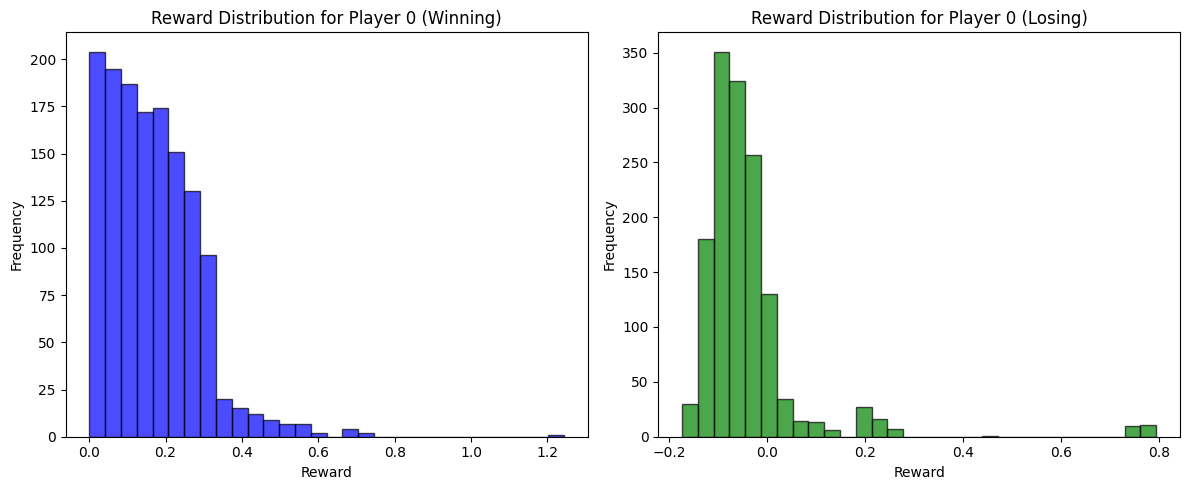

In [5]:
import matplotlib.pyplot as plt

# Extract rewards for each player group
win_rewards = [e.data.reward.item() for e in experiences if e.metadata.winning_player == "0"]
loss_rewards = [e.data.reward.item() for e in experiences if e.metadata.winning_player == "3"]

# Plot reward distributions
plt.figure(figsize=(12, 5))

# Player 0 rewards distribution
plt.subplot(1, 2, 1)
plt.hist(win_rewards, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title("Reward Distribution for Player 0 (Winning)")
plt.xlabel("Reward")
plt.ylabel("Frequency")

# Player 3 rewards distribution
plt.subplot(1, 2, 2)
plt.hist(loss_rewards, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title("Reward Distribution for Player 0 (Losing)")
plt.xlabel("Reward")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


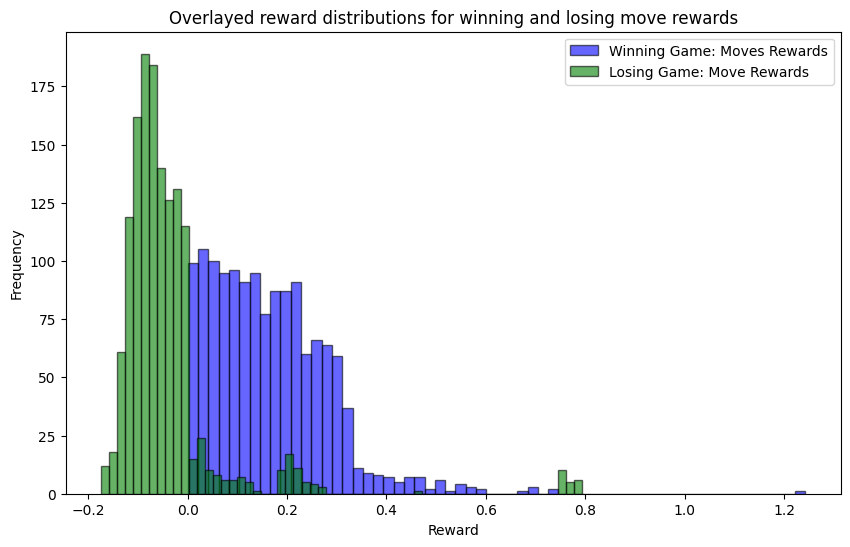

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(win_rewards, bins=60, alpha=0.6, color='blue', edgecolor='black', label="Winning Game: Moves Rewards")
plt.hist(loss_rewards, bins=60, alpha=0.6, color='green', edgecolor='black', label="Losing Game: Move Rewards")

plt.title("Overlayed reward distributions for winning and losing move rewards")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [8]:
from tqdm import tqdm
import torch
import random

# Shuffle and split the dataset into training and validation sets (80/20 split)
experience_datas = [e.data for e in experiences]
train_experiences, test_experiences = train_test_split(experience_datas, test_size=0.2, random_state=42)

# Define model parameters
state_dim = experience_datas[0].state.shape[0]
move_dim = experience_datas[0].action.shape[0]
gamma = 0.99
lr = 0.00001
batch_size = 256  # Configurable batch size
model_save_path = "dlq_agent_model_v003.pth"

In [9]:


# Initialize the DQL agent with specified dimensions
agent = DQLAgent(state_dim=state_dim, move_dim=move_dim, gamma=gamma, lr=lr, batch_size=batch_size)

# Training loop with validation at each epoch
print("Starting training...")
num_epochs = 25
with tqdm(range(num_epochs), desc="Training Progress") as epoch_bar:
    for epoch in epoch_bar:
        # Shuffle training data each epoch for better generalization
        random.shuffle(train_experiences)
        
        # Training phase
        for i in range(0, len(train_experiences), batch_size):
            batch_experiences = train_experiences[i:i + batch_size]
            for experience in batch_experiences:
                agent.store_experience(experience)  # Store each experience in the batch
            agent.train()  # Train on the batch

        # Validation phase
        validation = DqlModelValidation(agent.q_network, gamma=gamma, test_set=test_experiences, validation_set=train_experiences)
        results = validation.validate()
        
        # Update the progress bar with validation results
        epoch_bar.set_postfix({
            "Test Error": f"{results['test_error']:.4f}",
            "Validation Error": f"{results['validation_error']:.4f}"
        })

print("Training complete.")

# Save the trained model
torch.save(agent.q_network.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")
# it ticketd up to Training Progress:  48%|████▊     | 31/65 [05:42<06:15, 11.06s/it, Test Error=298.2045, Validation Error=296.9166]

Starting training...


Training Progress: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s, Test Error=0.5033, Validation Error=0.4995]

Training complete.
Model saved to dlq_agent_model_v003.pth


Model loaded successfully from dlq_agent_model_v003.pth
Model loaded successfully from dlq_agent_model_v003.pth


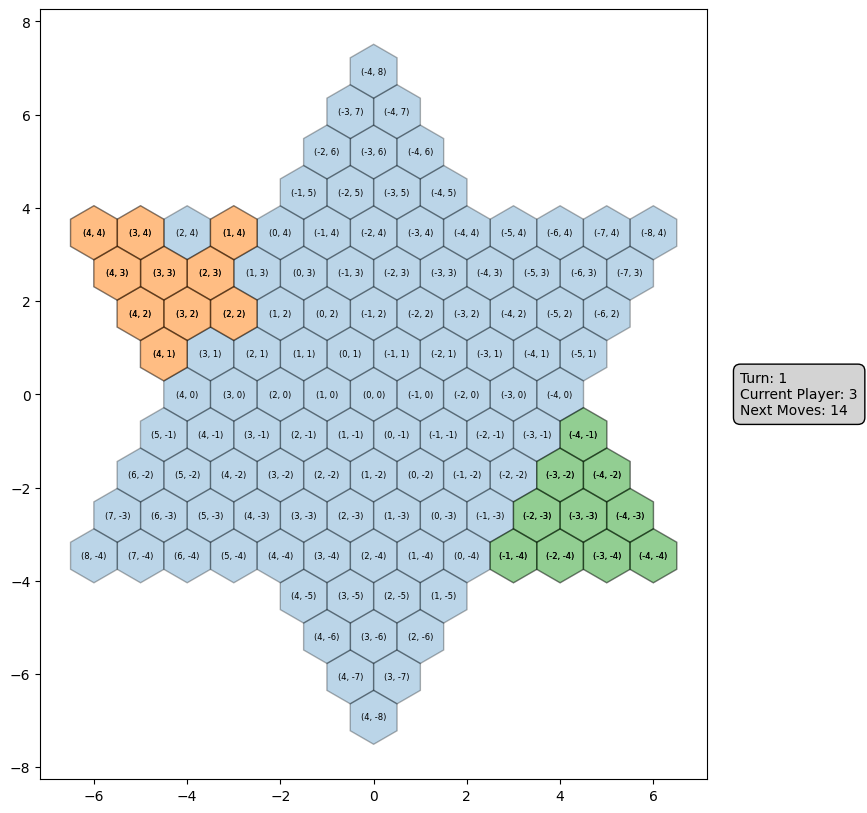

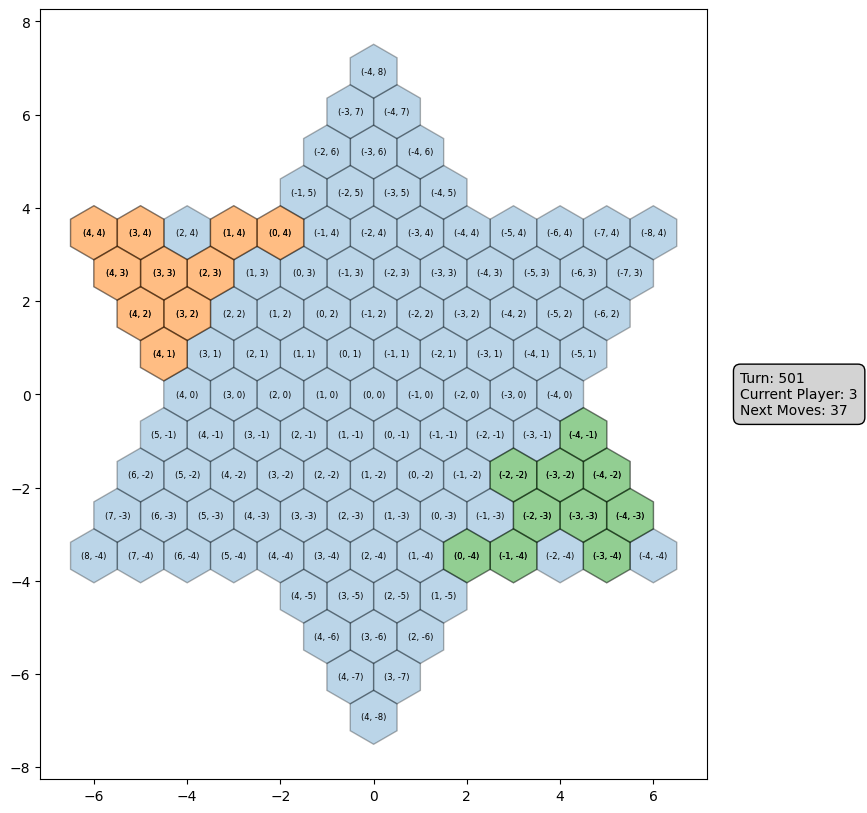

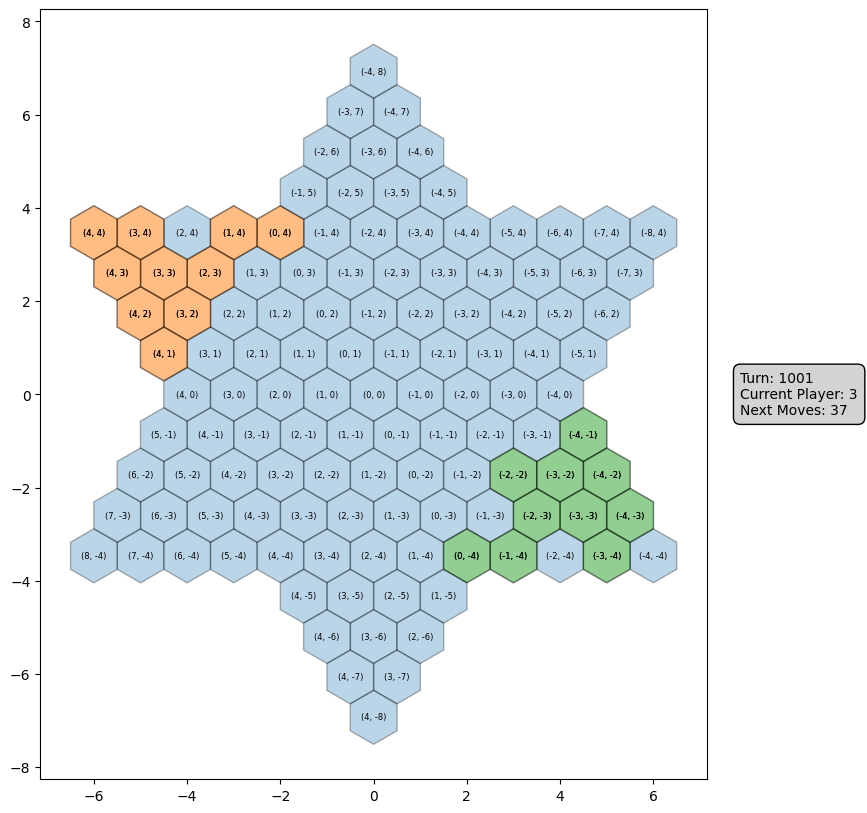

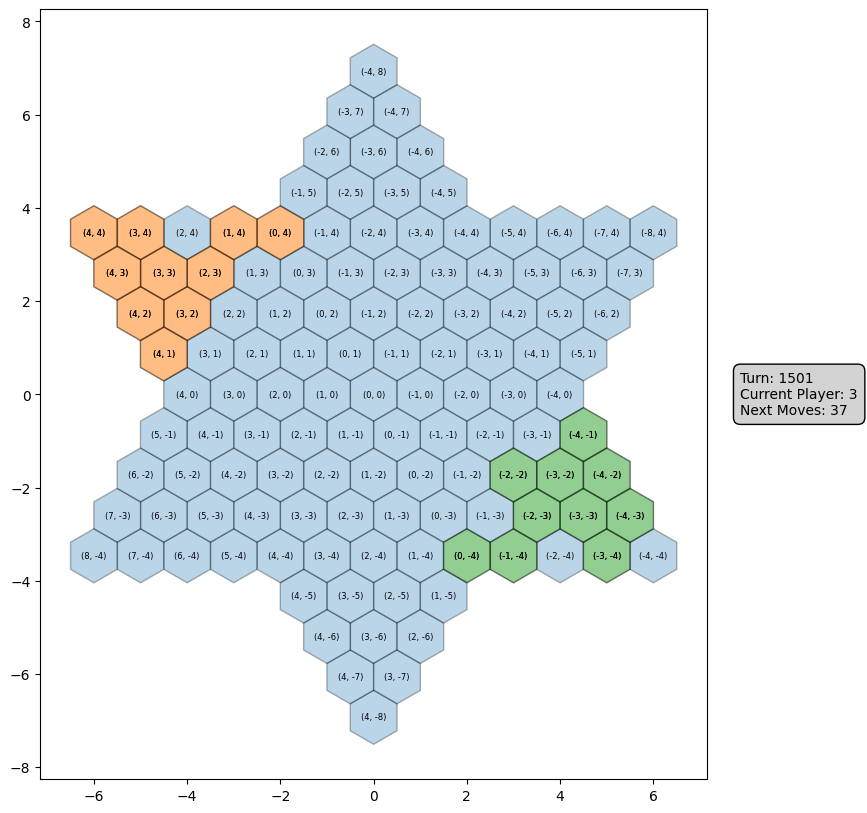

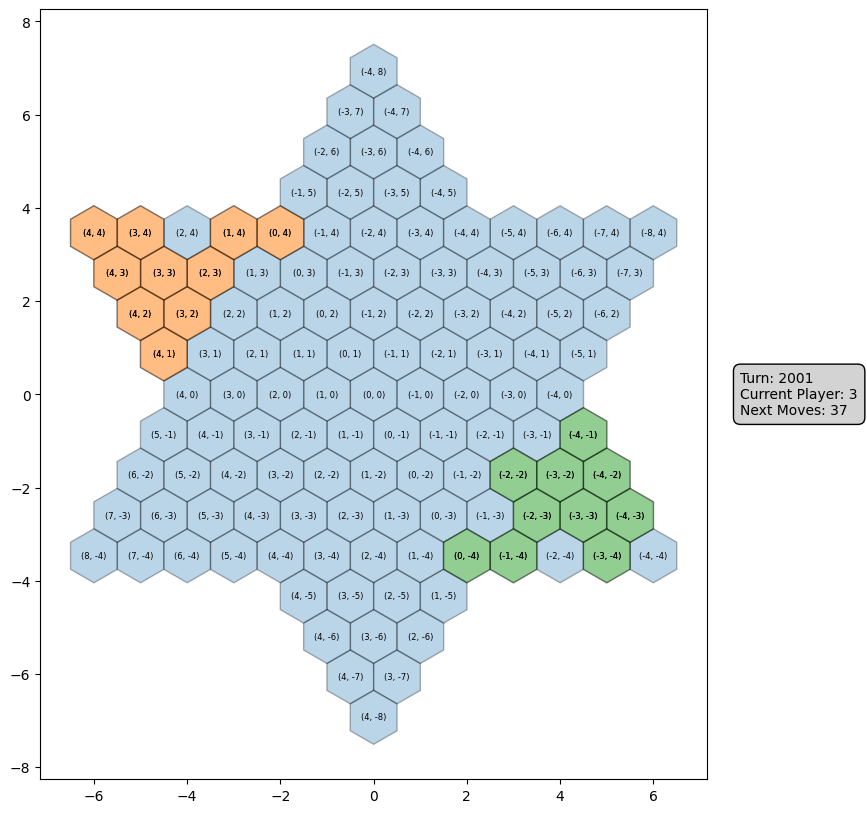

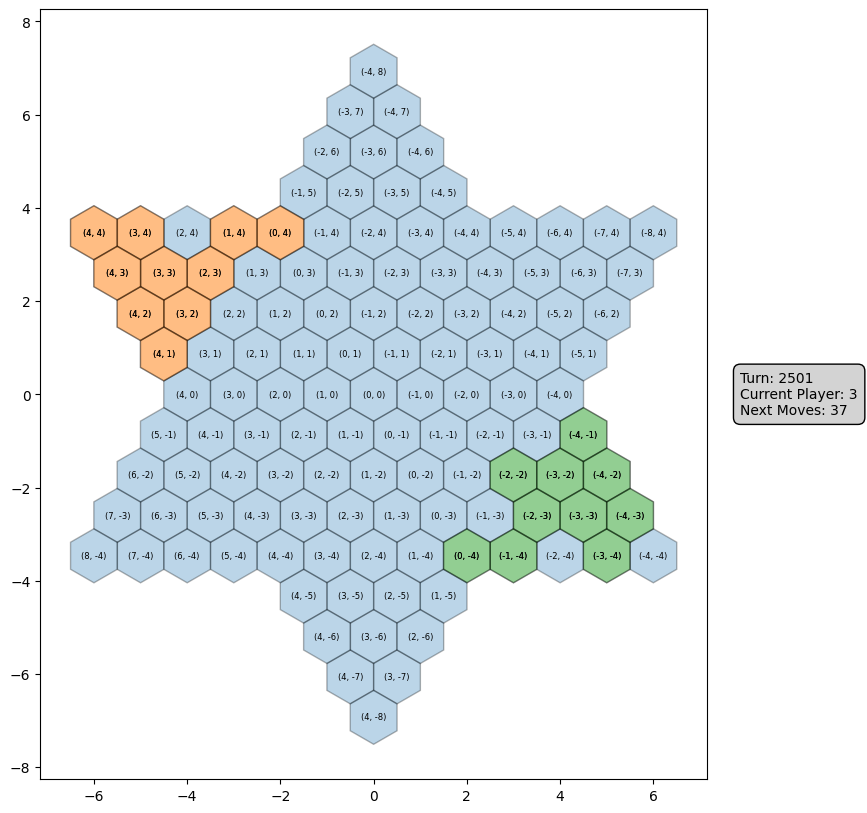

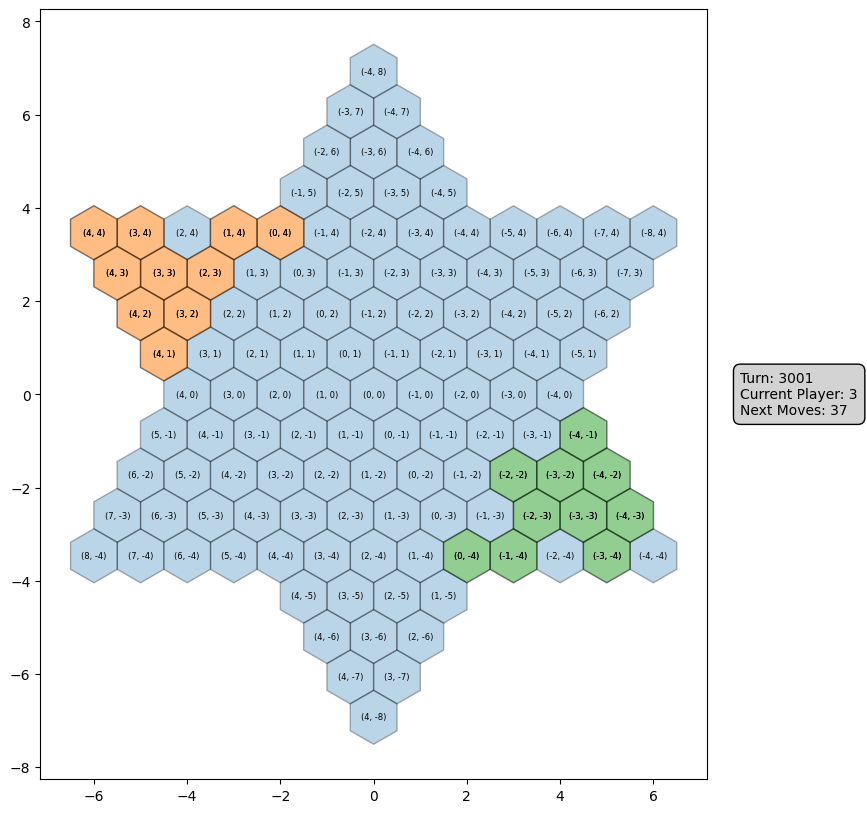

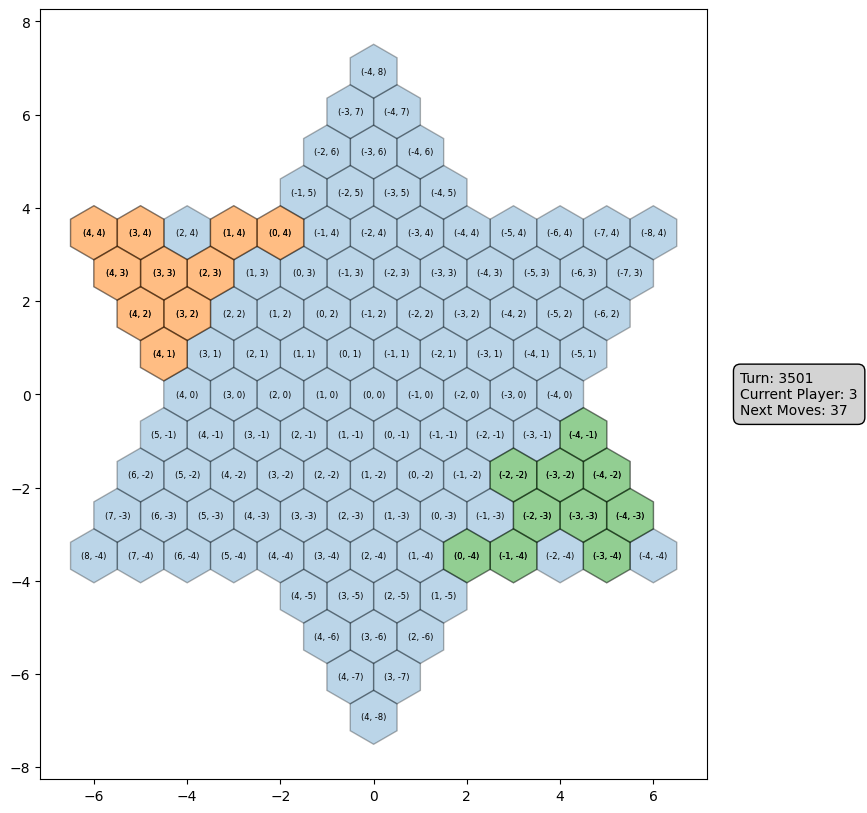

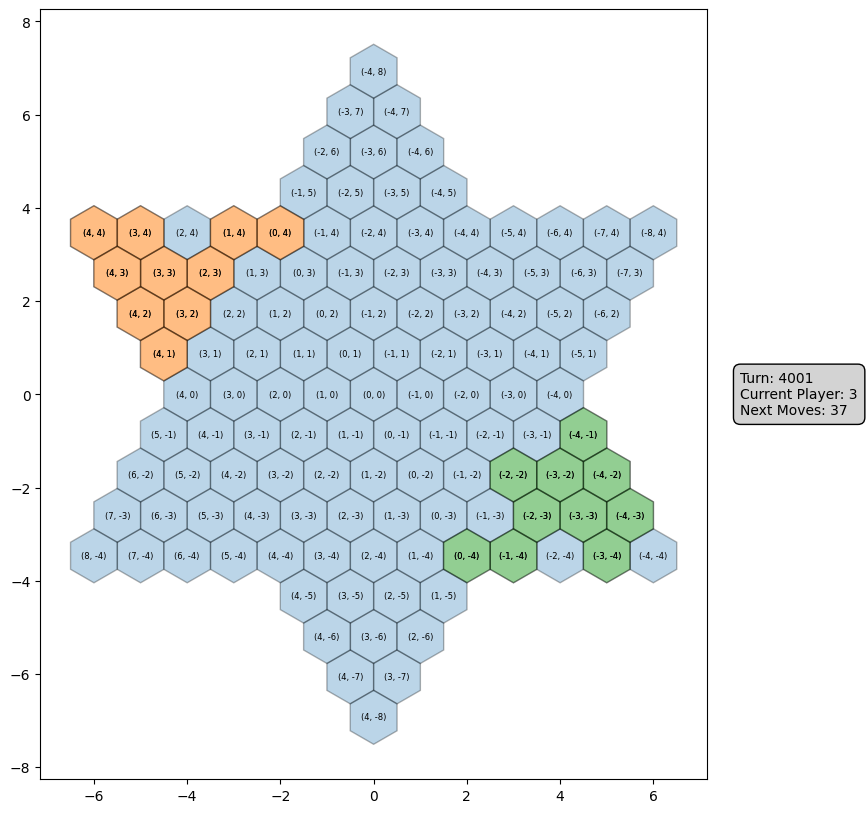

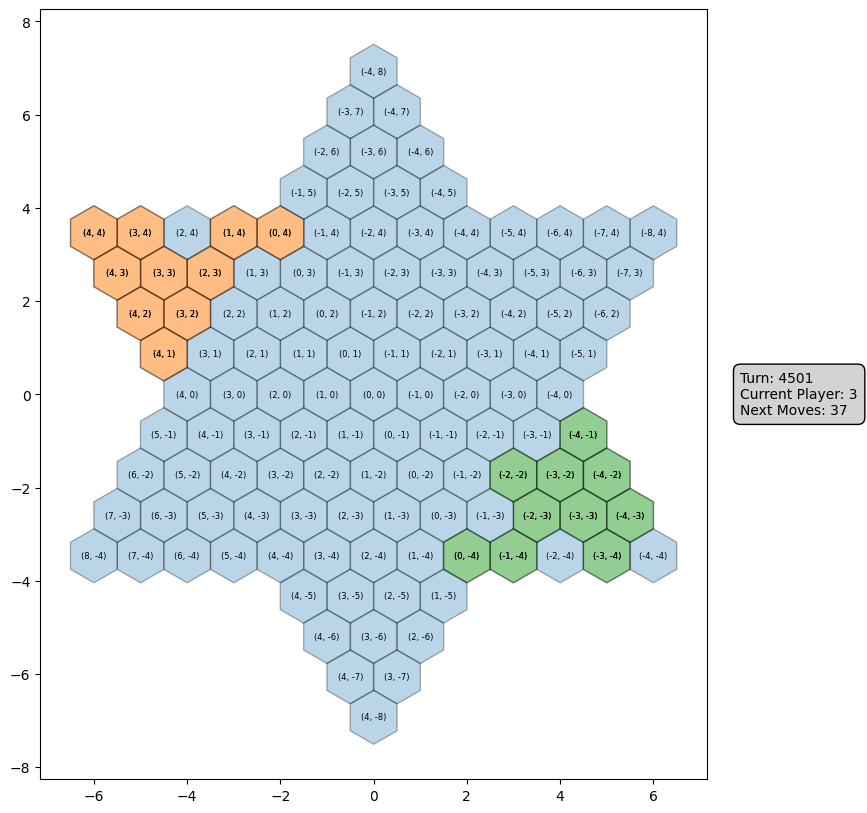

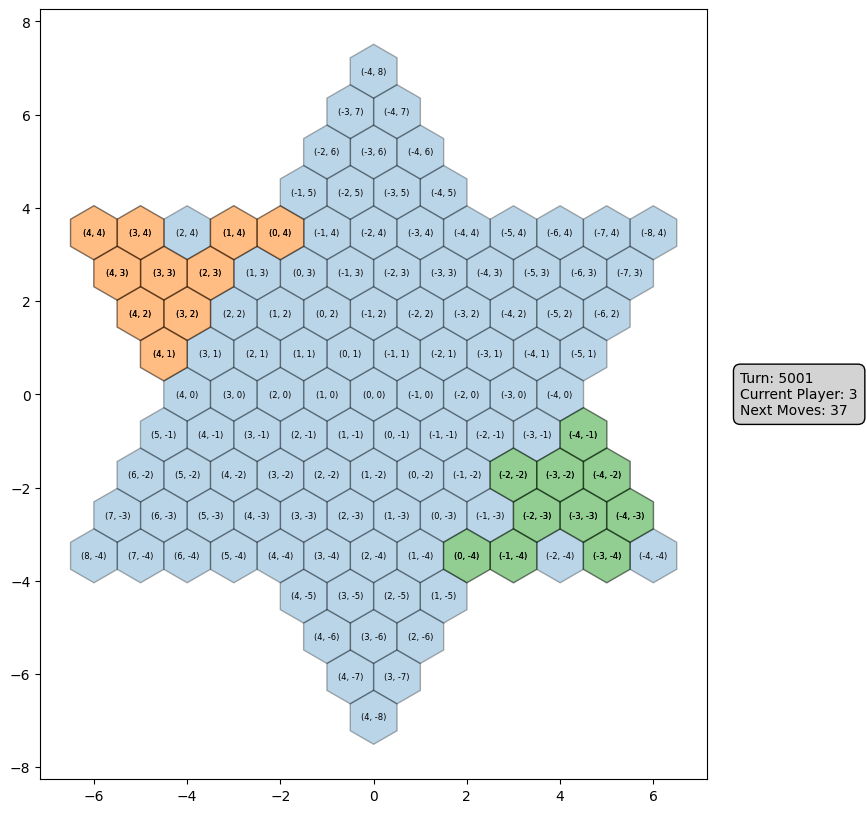

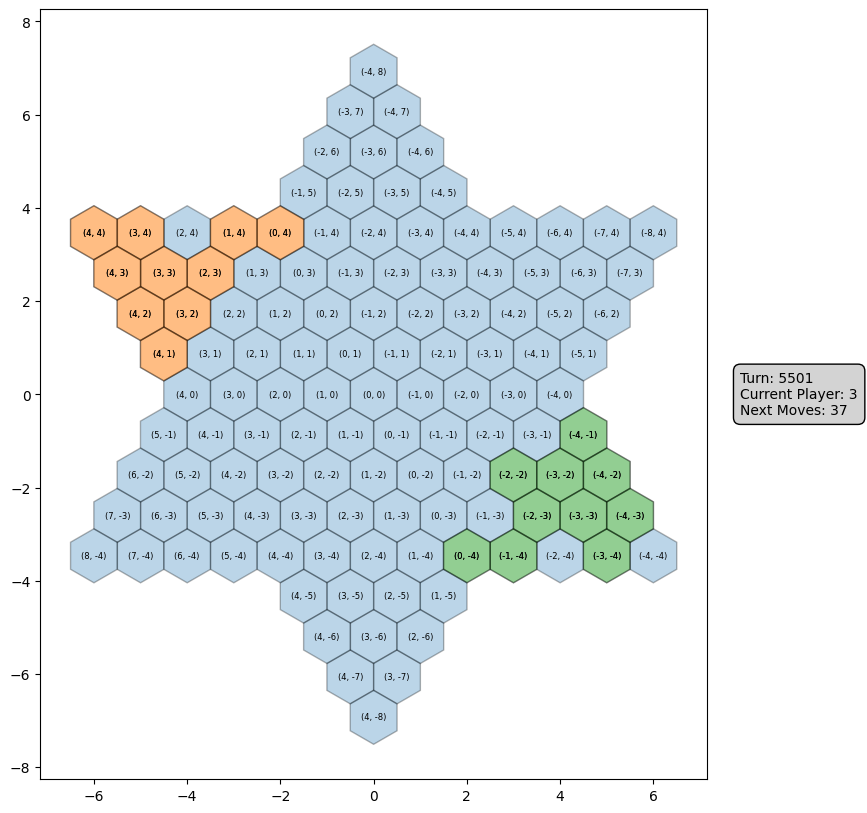

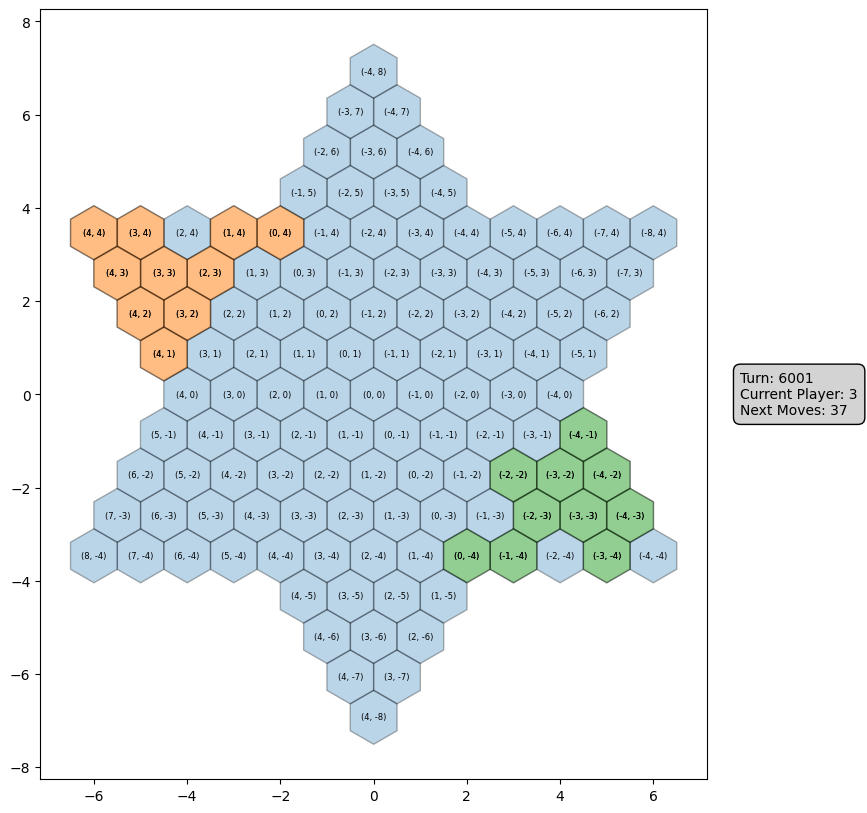

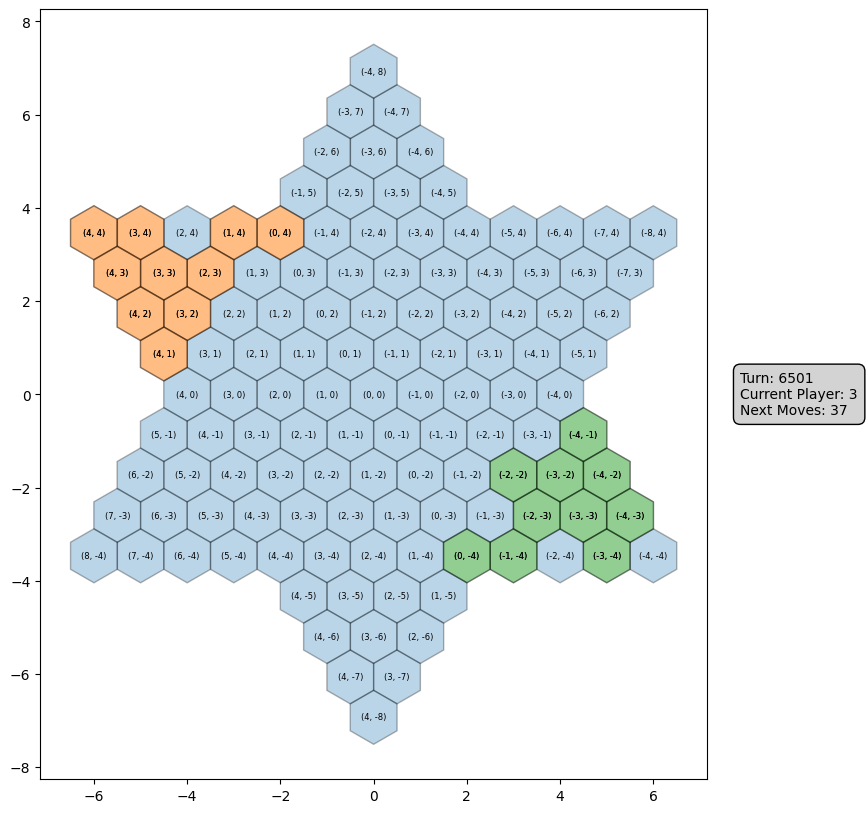

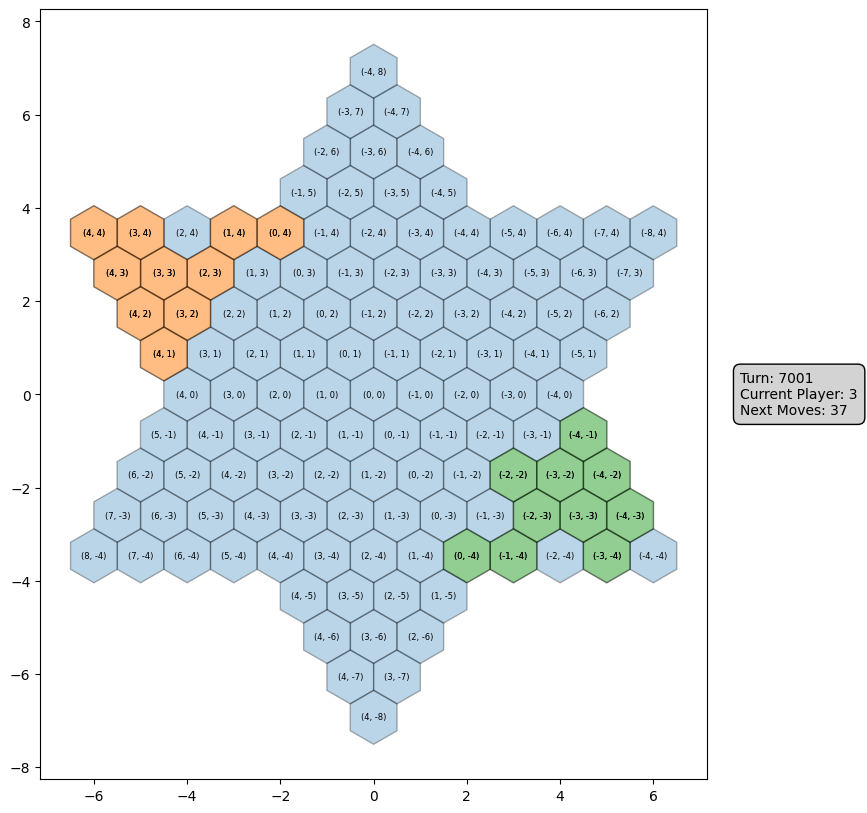

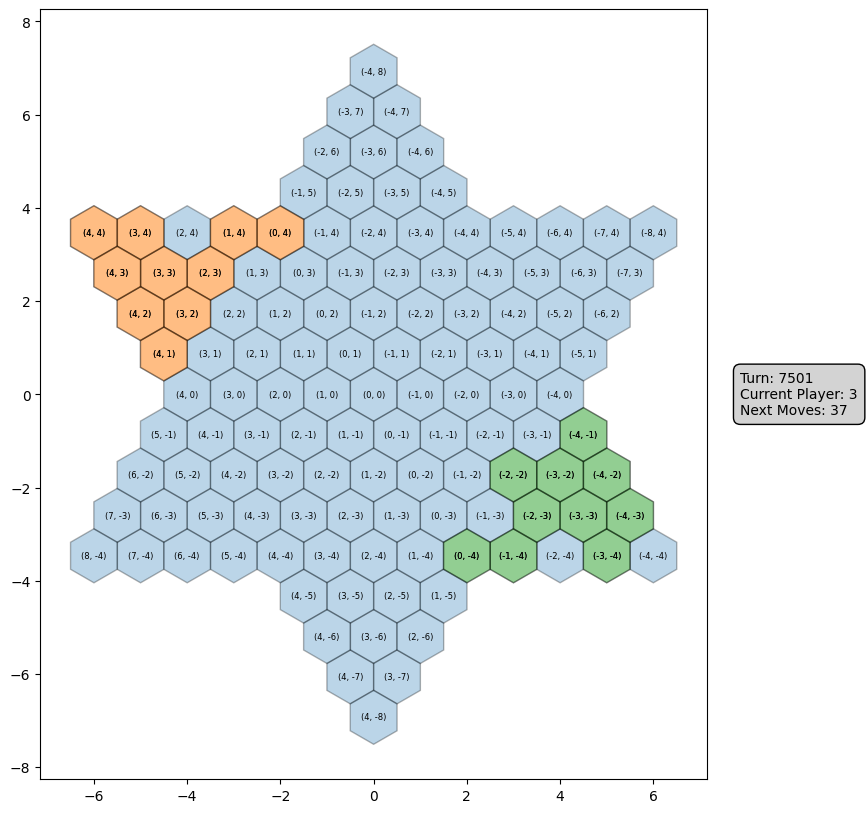

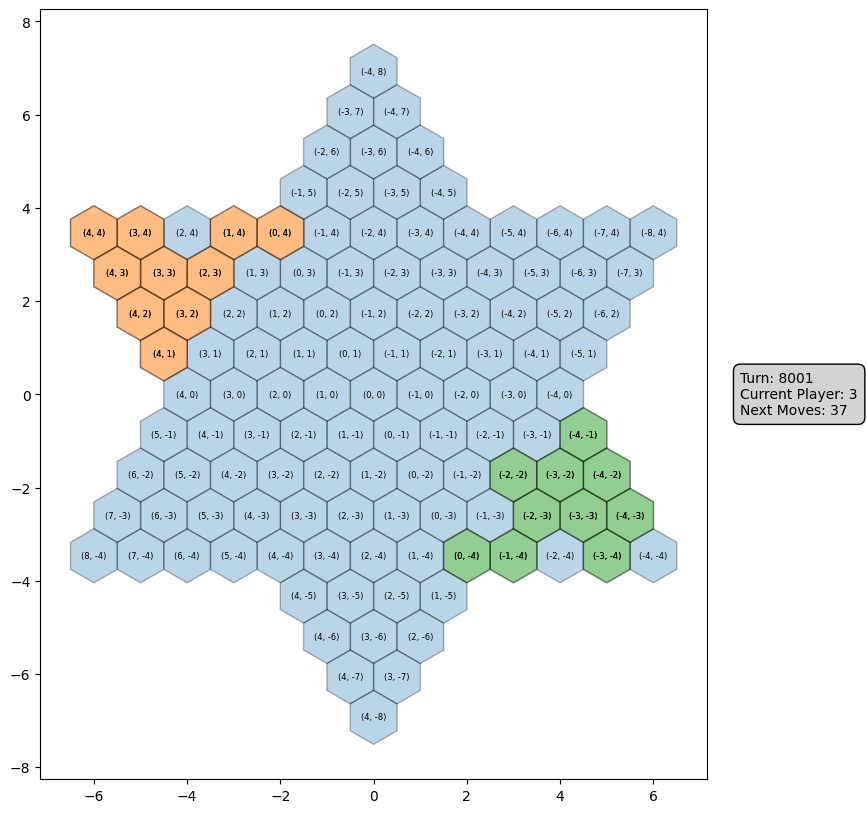

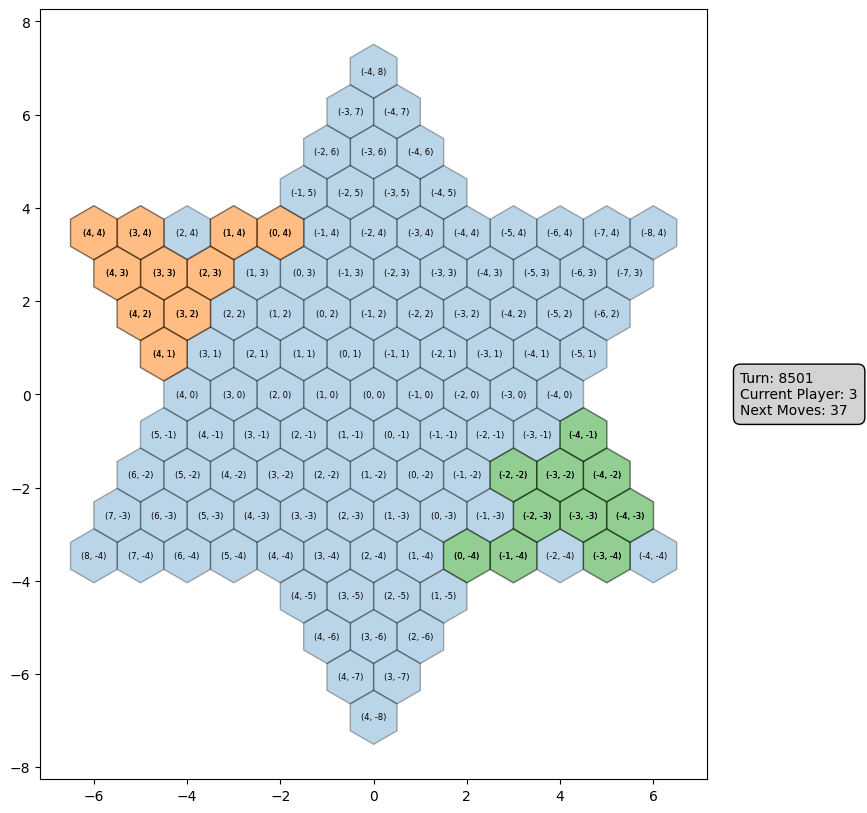

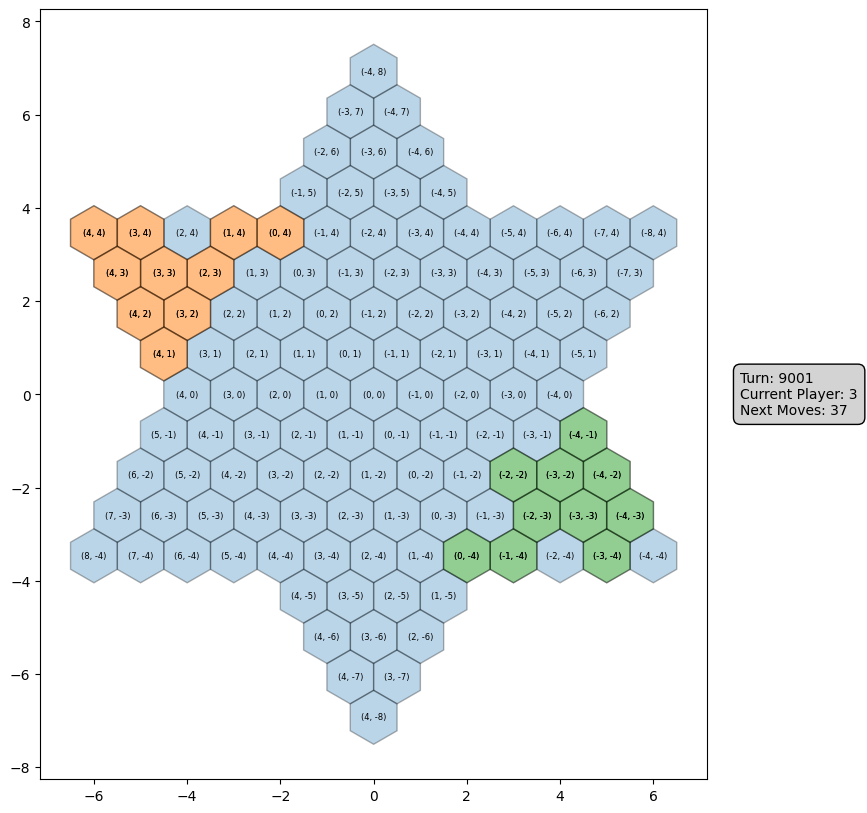

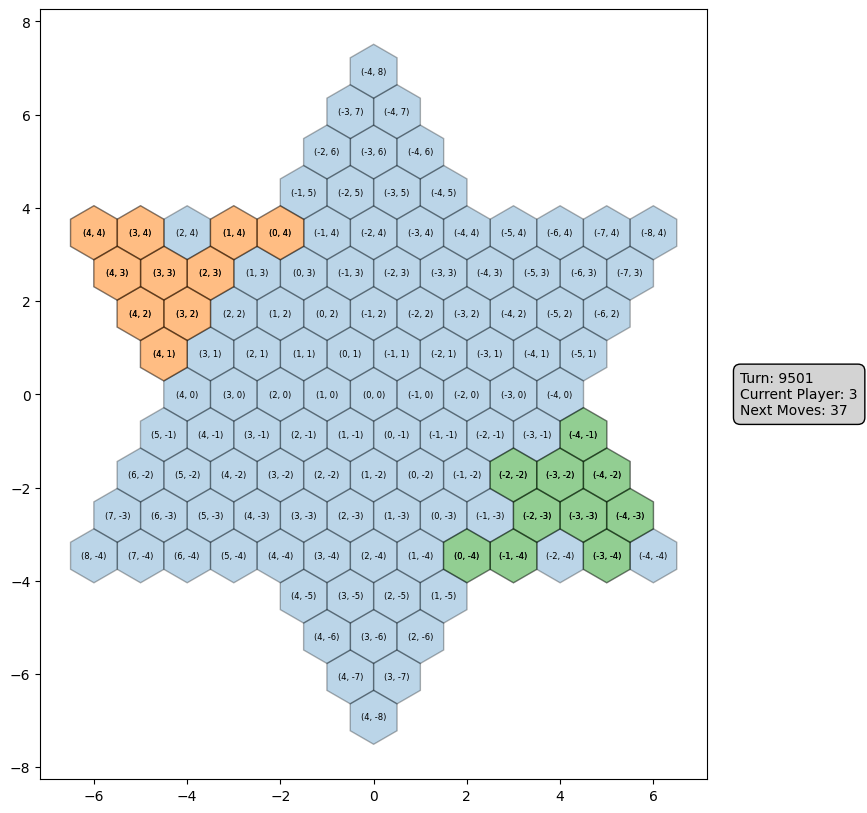

In [11]:


# # Enable logging if needed
# logging.basicConfig(level=logging.INFO)

# bootstrap_model = BootstrapModel()
dql_model = DqlModel(
    q_network_path="dlq_agent_model_v003.pth", 
    state_dim=state_dim,                                
    action_dim=move_dim,                              
    board_size=4                               
)

dql_model_2 = DqlModel(
    q_network_path="dlq_agent_model_v003.pth", 
    state_dim=state_dim,                                
    action_dim=move_dim,                              
    board_size=4                               
)

# Simulate the game using the models
game_simulation = GameSimulation.simulate_game(
    models=[dql_model, dql_model_2],  # DQL model plays against the bootstrap model
    name="dql_vs_bootstrap_simulation",
    version="v1.0.0",
    print_period=500,
    show_coordinates=True,
    max_turns=10000
)


In [12]:
game_simulation.save_animation()

Creating Animation:   0%|          | 0/10001 [00:00<?, ?it/s]



Current Player: 0 
Move(0, -2), Position(2, 4)
Turn: 0

Current Player: 3 
Move(0, 2), Position(-2, -4)
Turn: 1

Current Player: 0 
Move(-4, 0), Position(4, 4)
Turn: 2

Current Player: 3 
Move(4, 0), Position(-4, -4)
Turn: 3

Current Player: 0 
Move(2, 2), Position(2, 2)
Turn: 4

Current Player: 3 
Move(-2, -2), Position(-2, -2)
Turn: 5

Current Player: 0 
Move(-2, -2), Position(4, 4)
Turn: 6

Current Player: 3 
Move(2, 2), Position(-4, -4)
Turn: 7

Current Player: 0 
Move(2, 2), Position(2, 2)
Turn: 8

Current Player: 3 
Move(-2, -2), Position(-2, -2)
Turn: 9

Current Player: 0 
Move(-2, -2), Position(4, 4)
Turn: 10

Current Player: 3 
Move(2, 2), Position(-4, -4)
Turn: 11

Current Player: 0 
Move(2, 2), Position(2, 2)
Turn: 12

Current Player: 3 
Move(-2, -2), Position(-2, -2)
Turn: 13

Current Player: 0 
Move(-2, -2), Position(4, 4)
Turn: 14

Current Player: 3 
Move(2, 2), Position(-4, -4)
Turn: 15

Current Player: 0 
Move(2, 2), Position(2, 2)
Turn: 16

Current Player: 3 
Move(-2,

C:\Users\dakot\Documents\Stanford\CS223\ChineseCheckersGameEngine\ChineseCheckersGameEngine\src\chinese_checkers\geometry\Printer.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, figsize=(plot_size, plot_size))


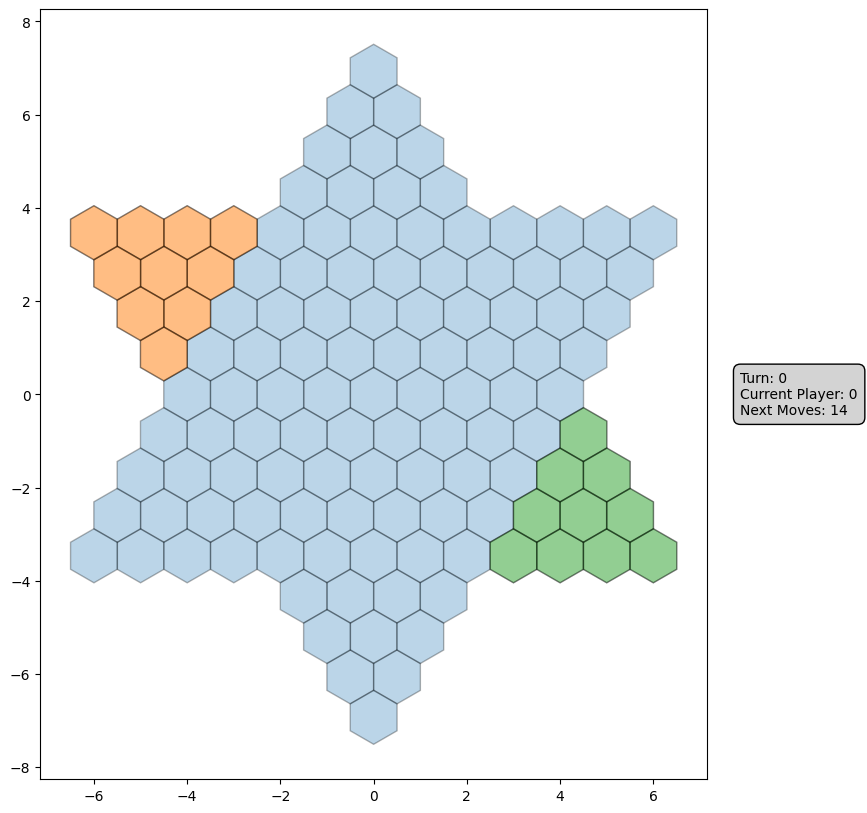

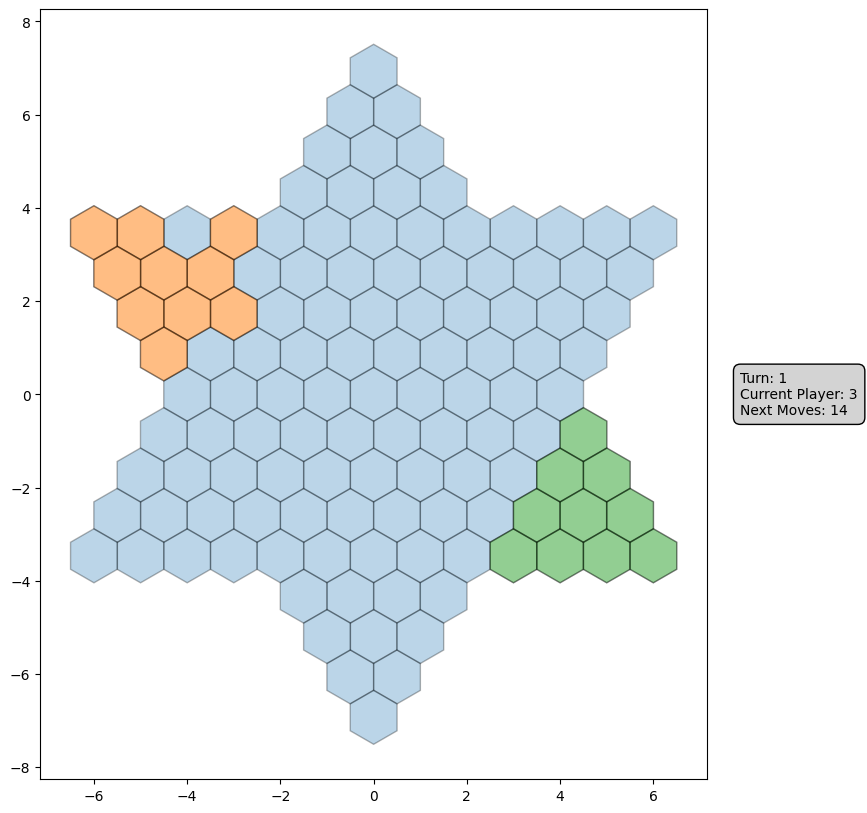

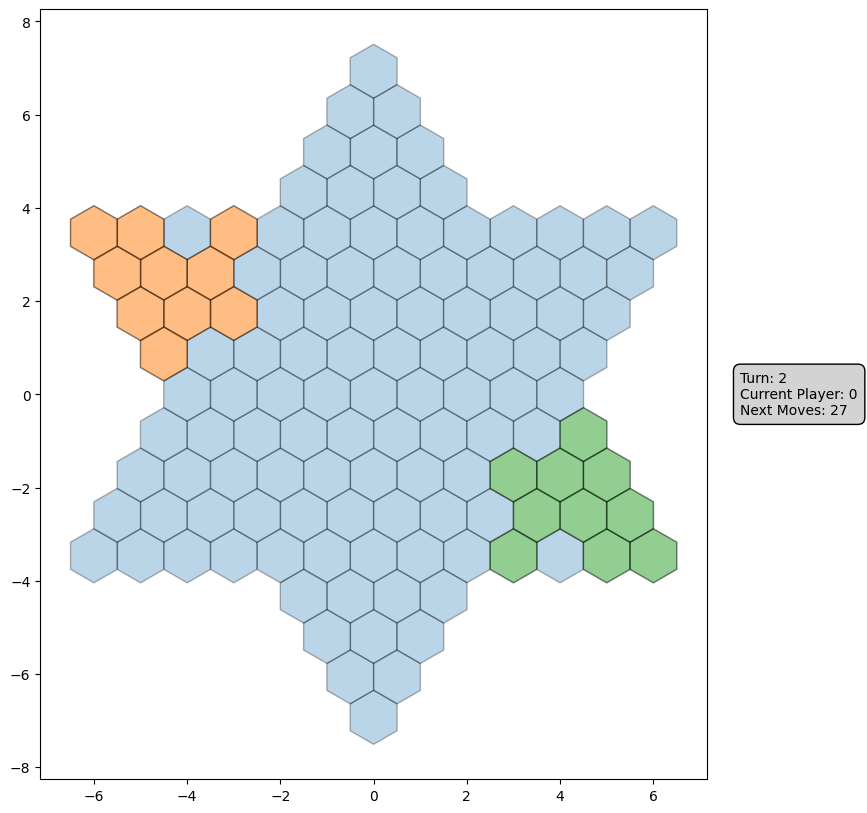

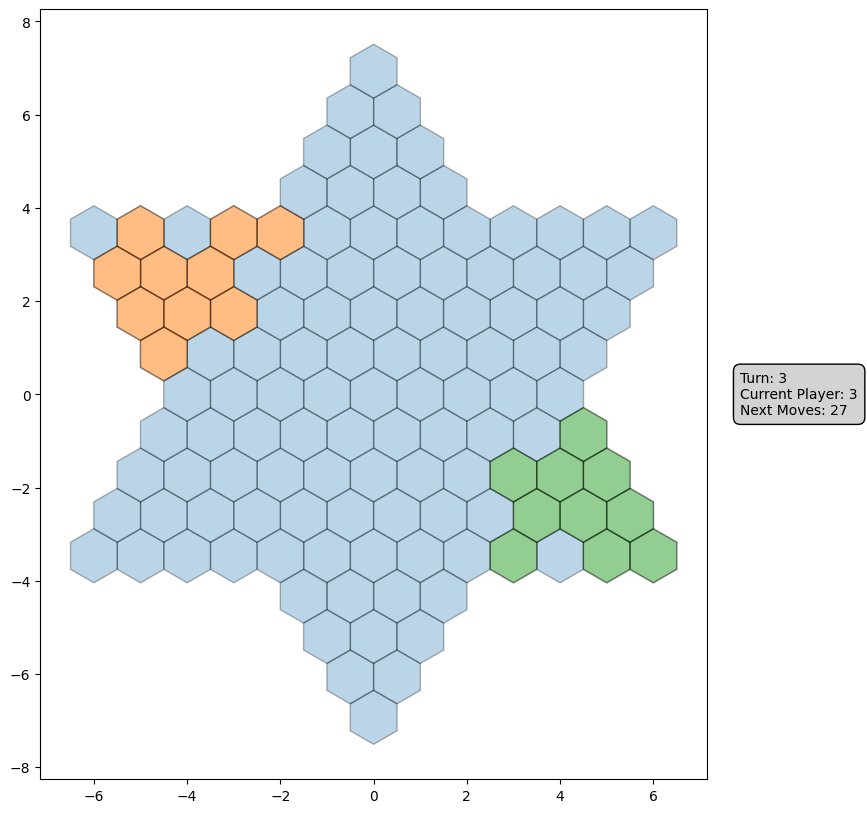

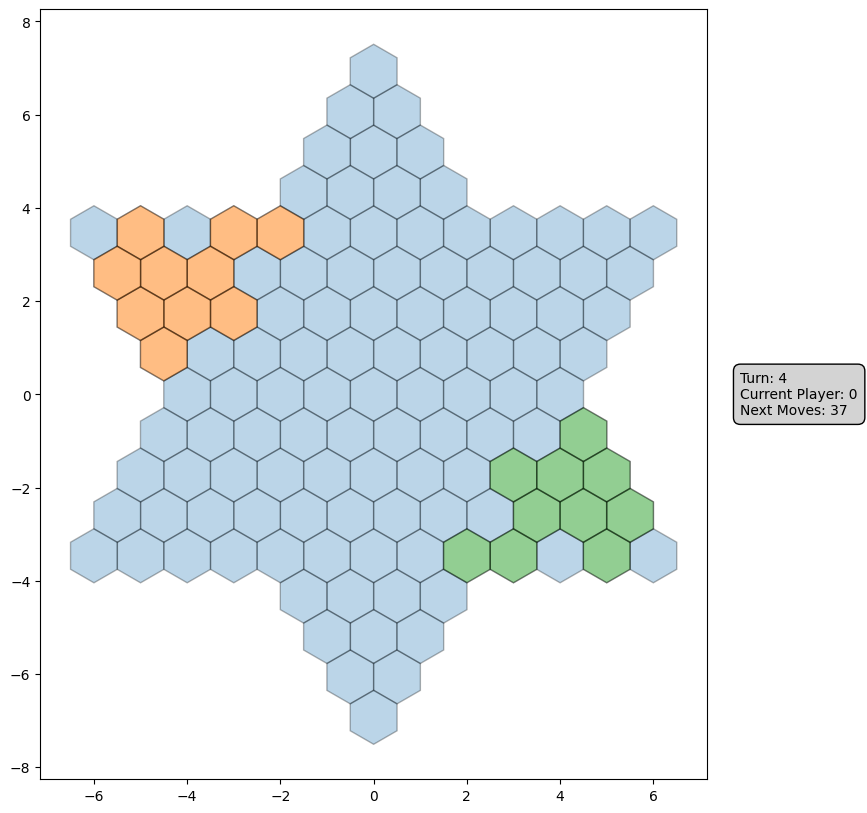

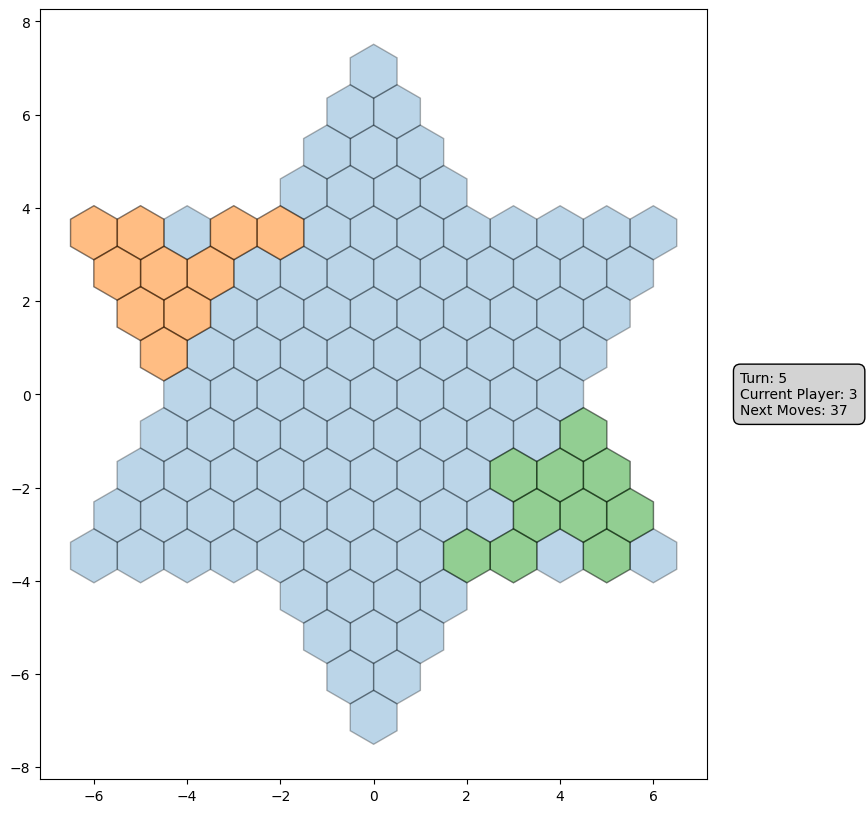

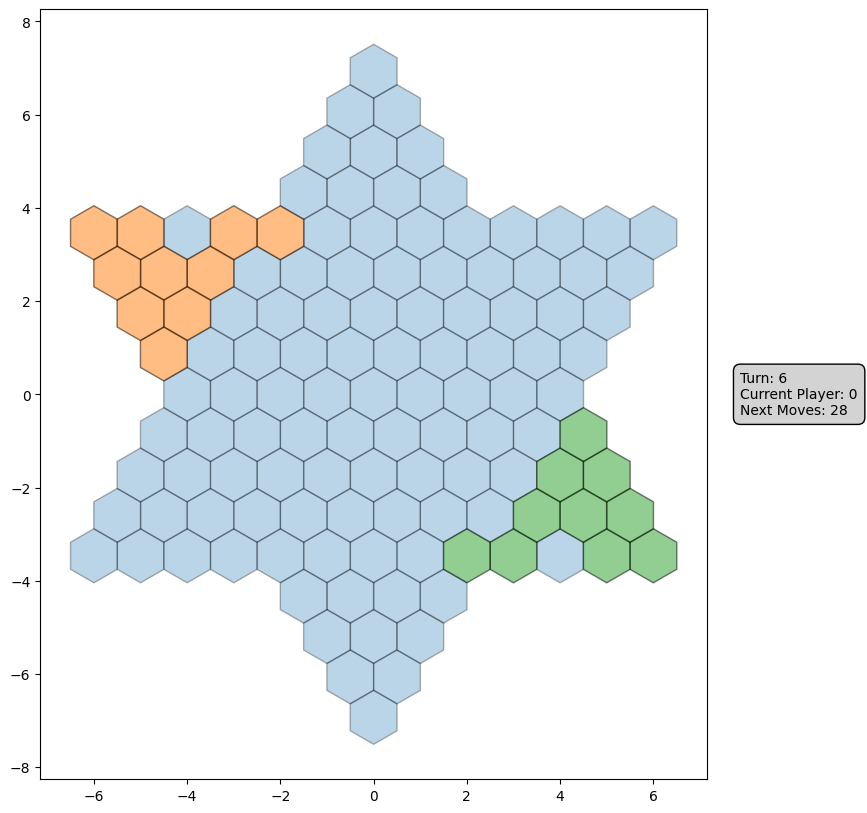

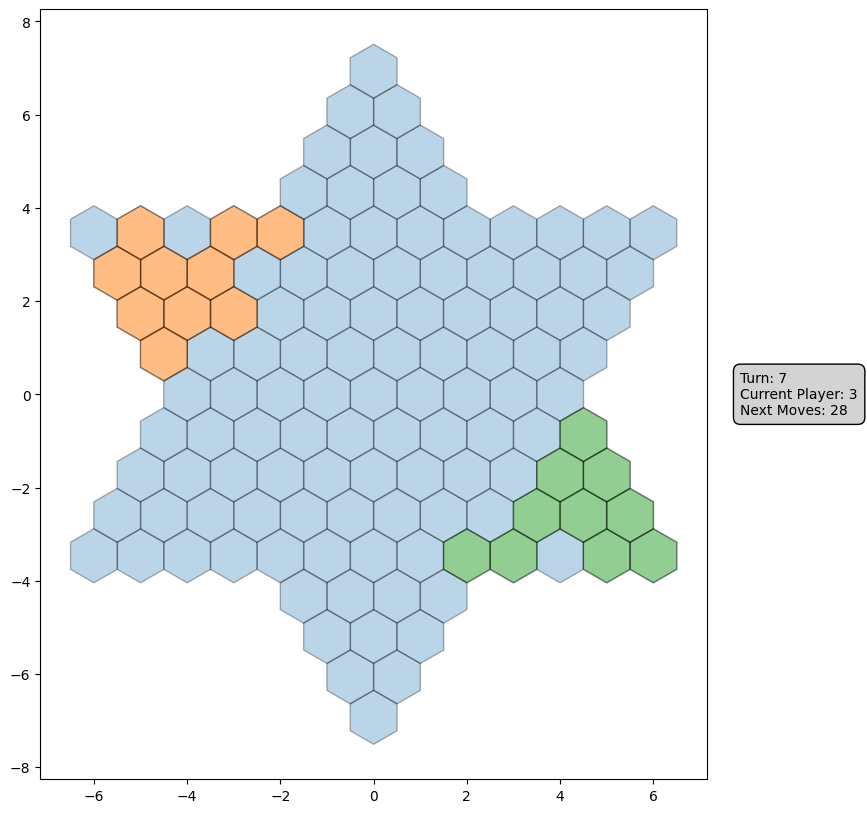

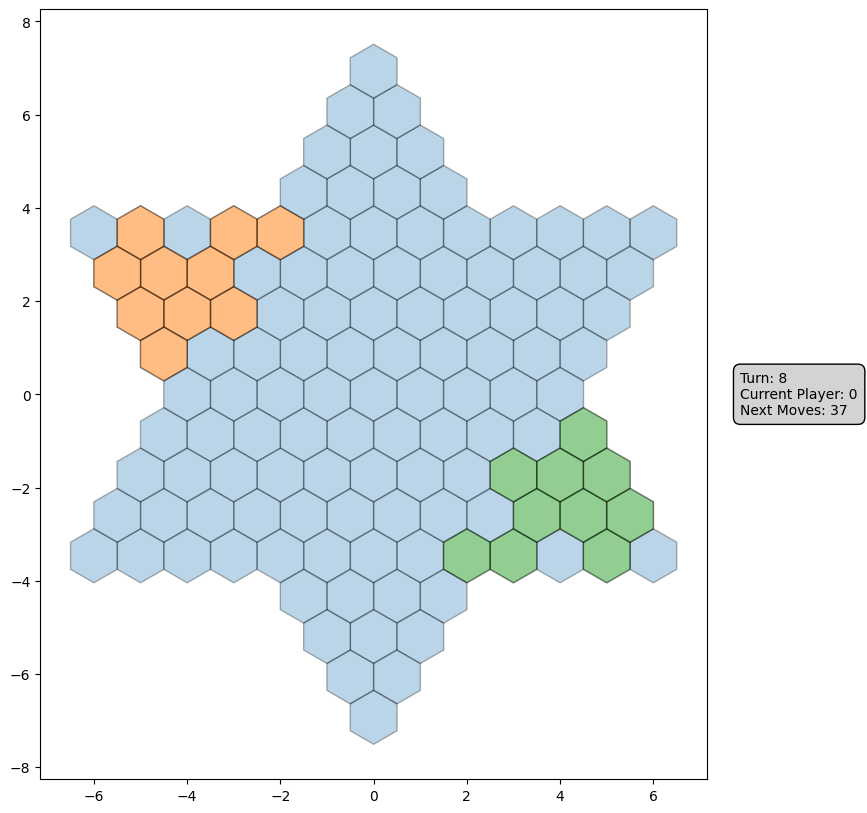

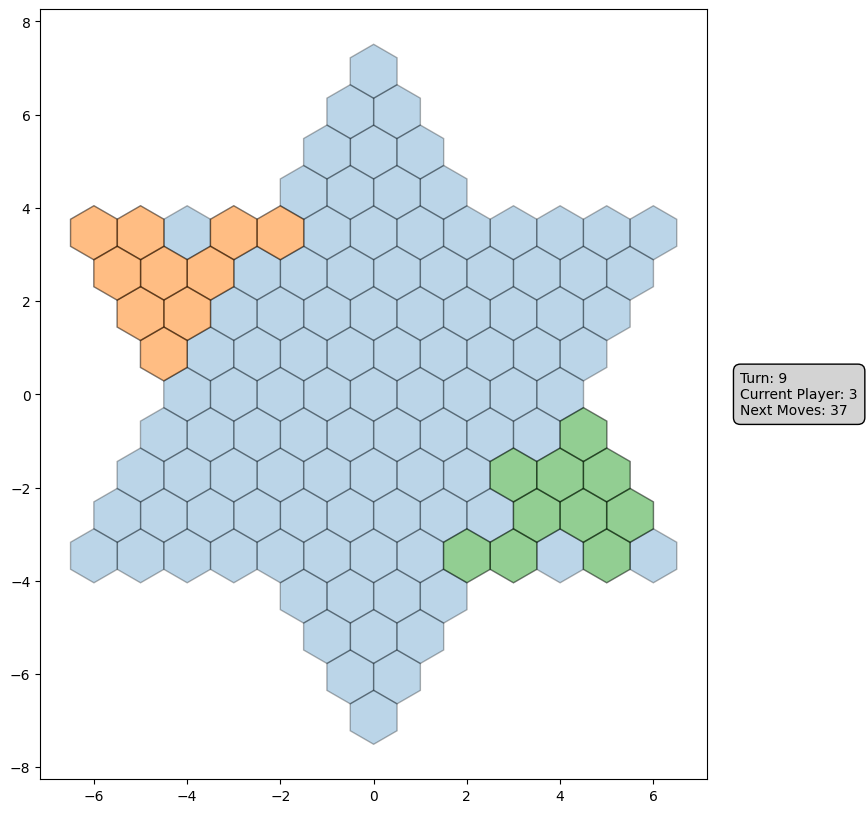

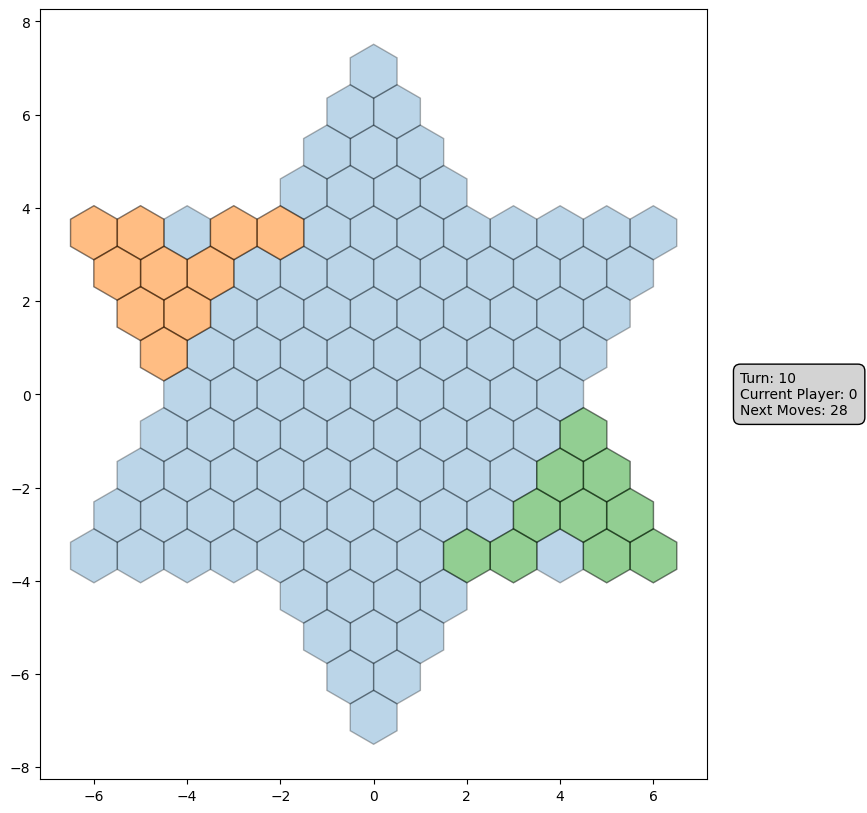

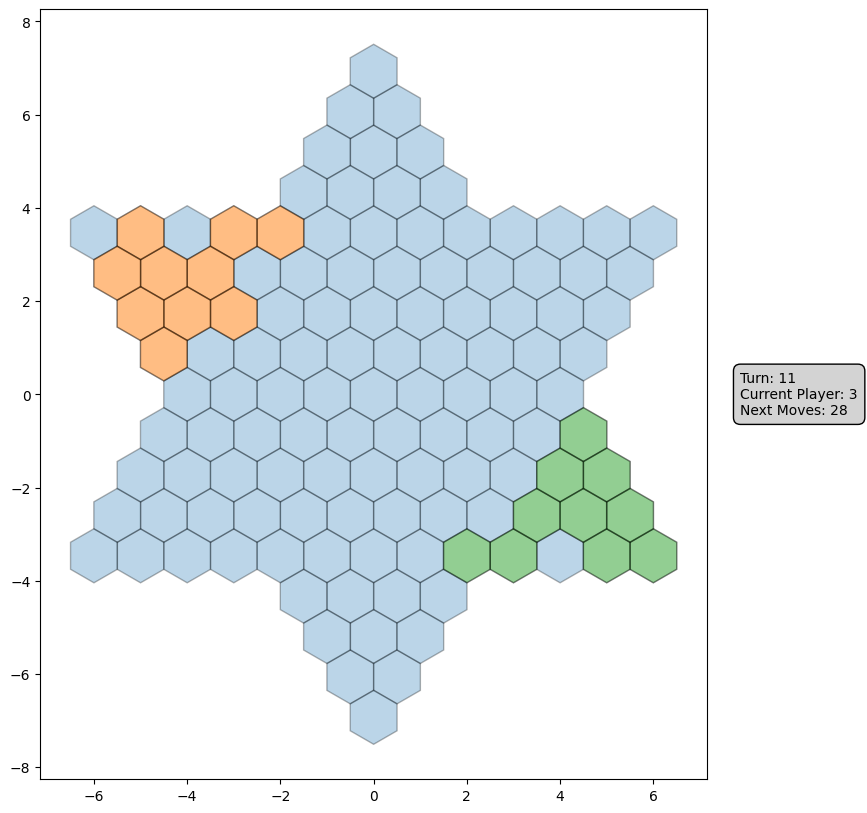

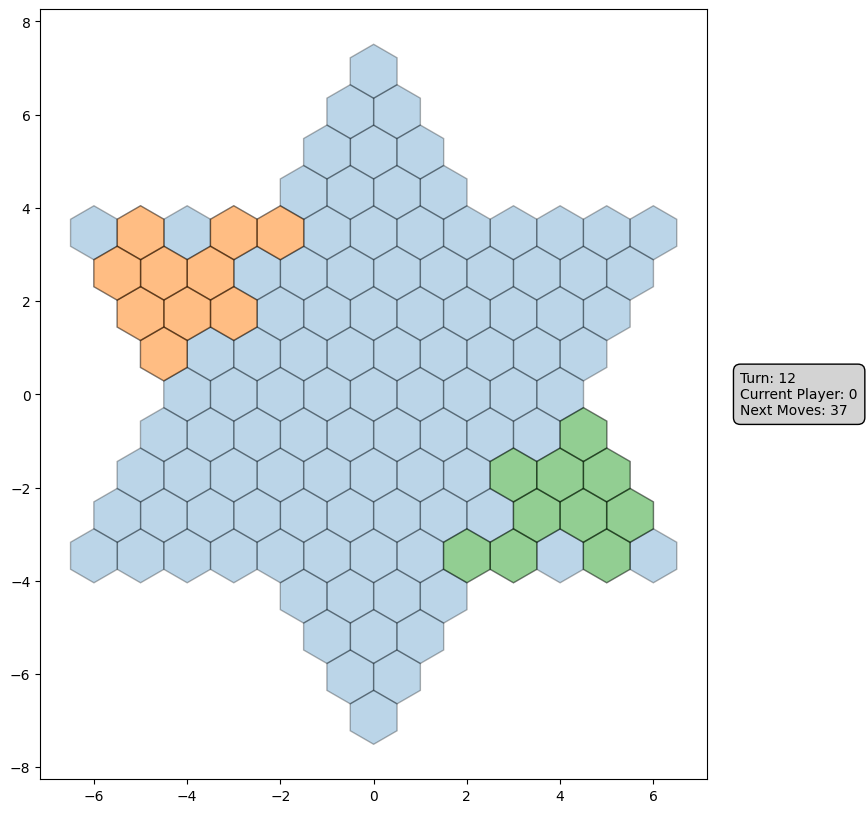

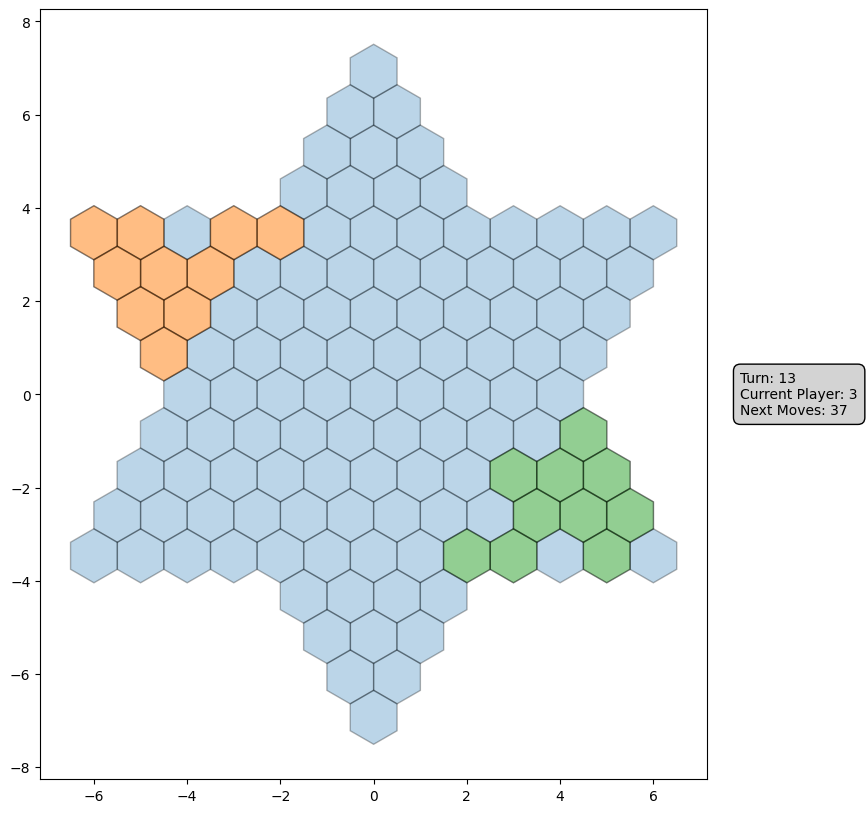

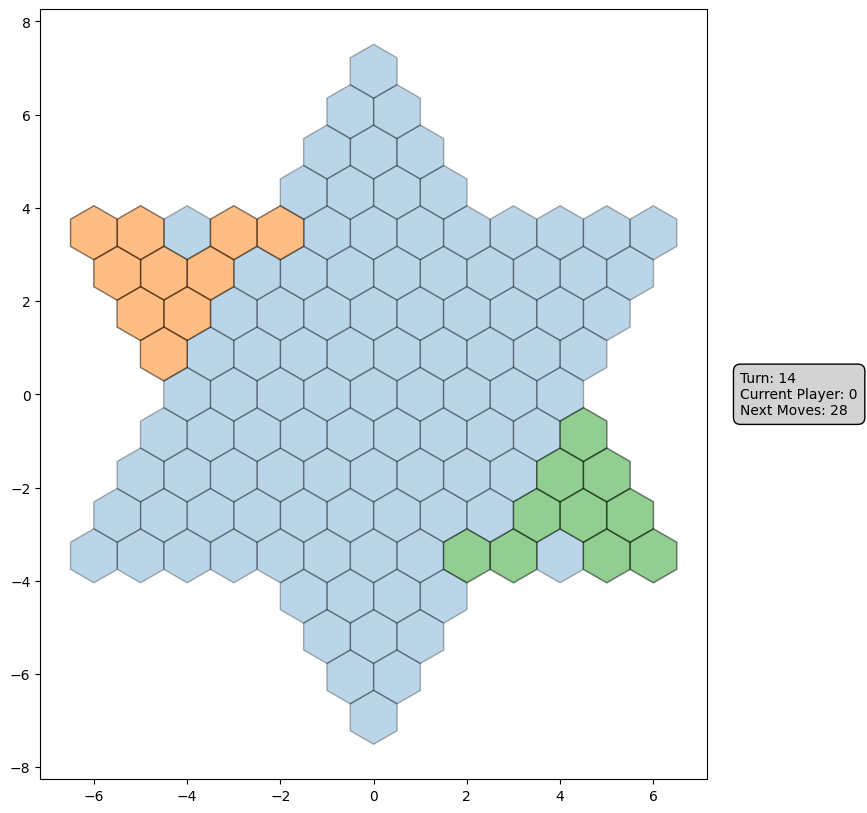

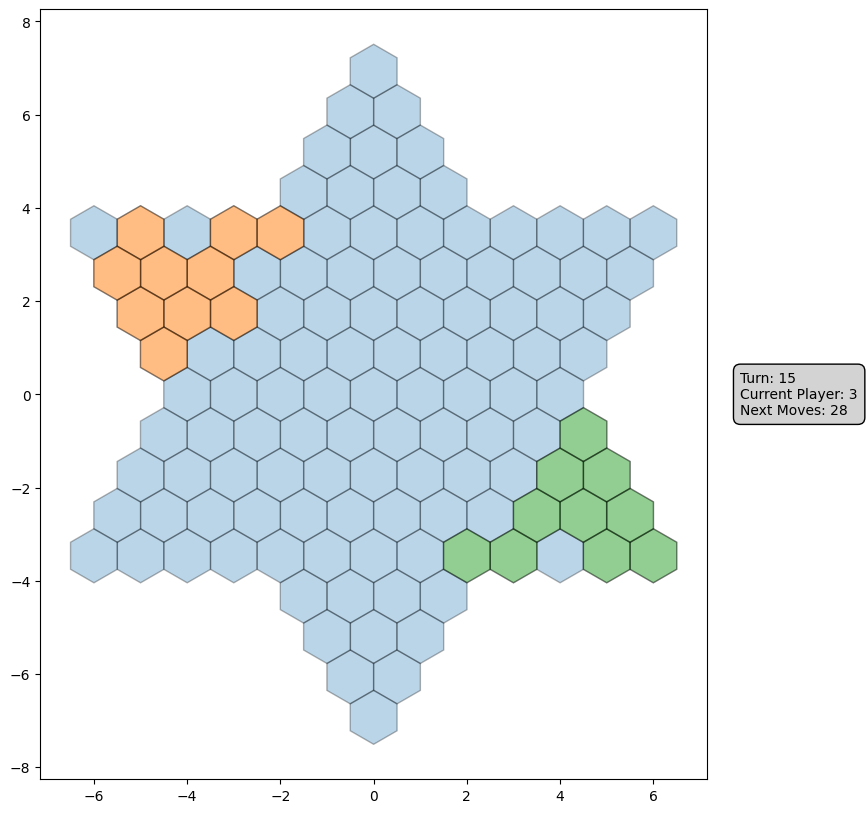

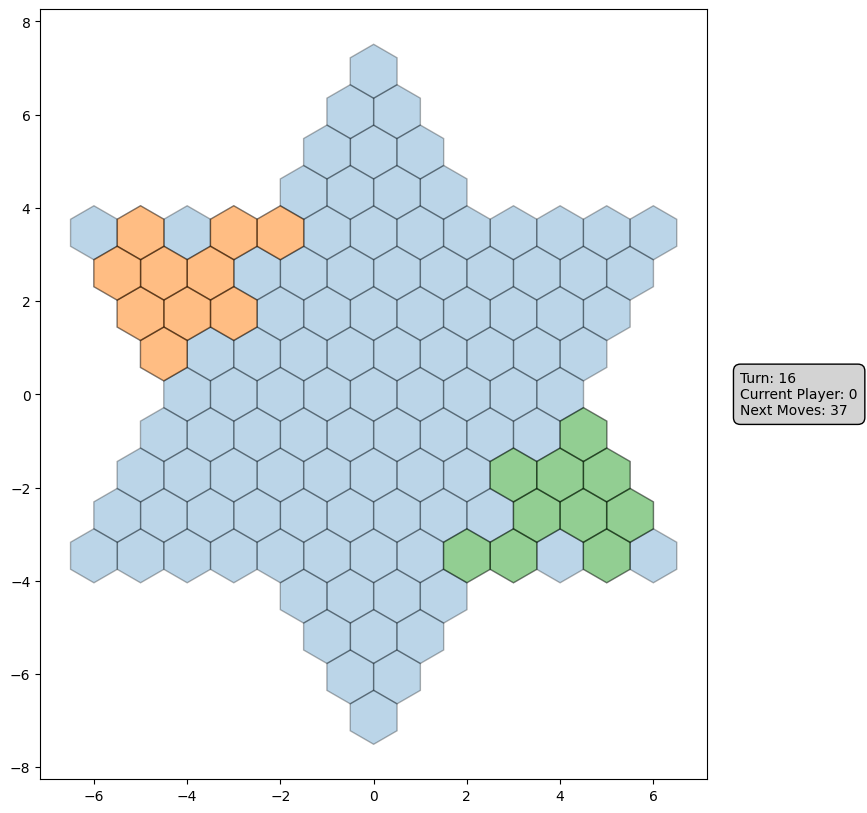

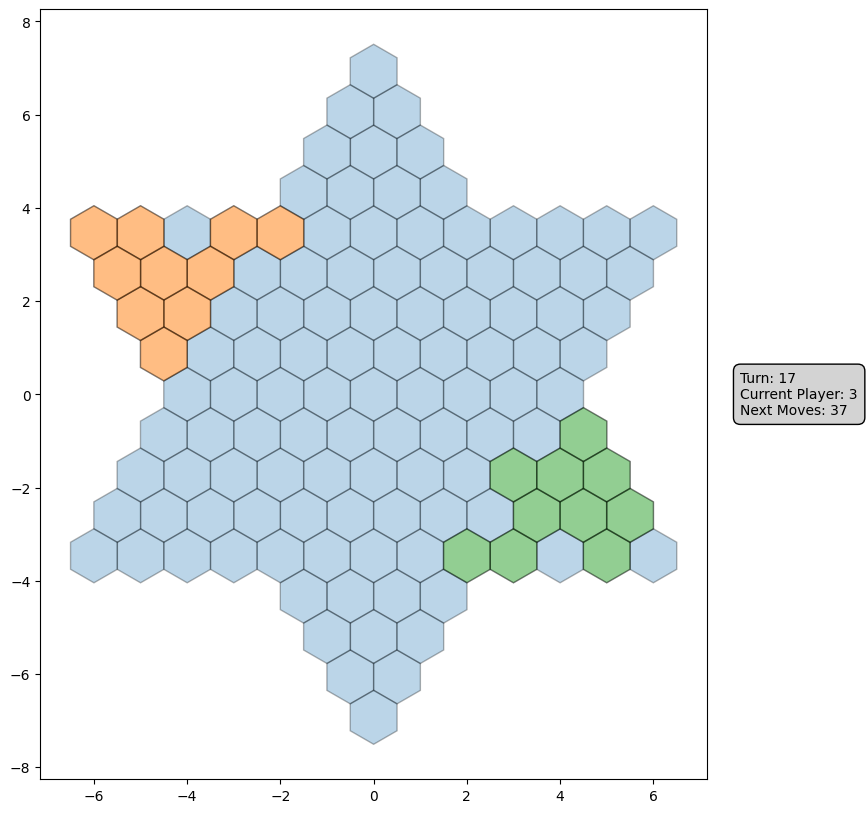

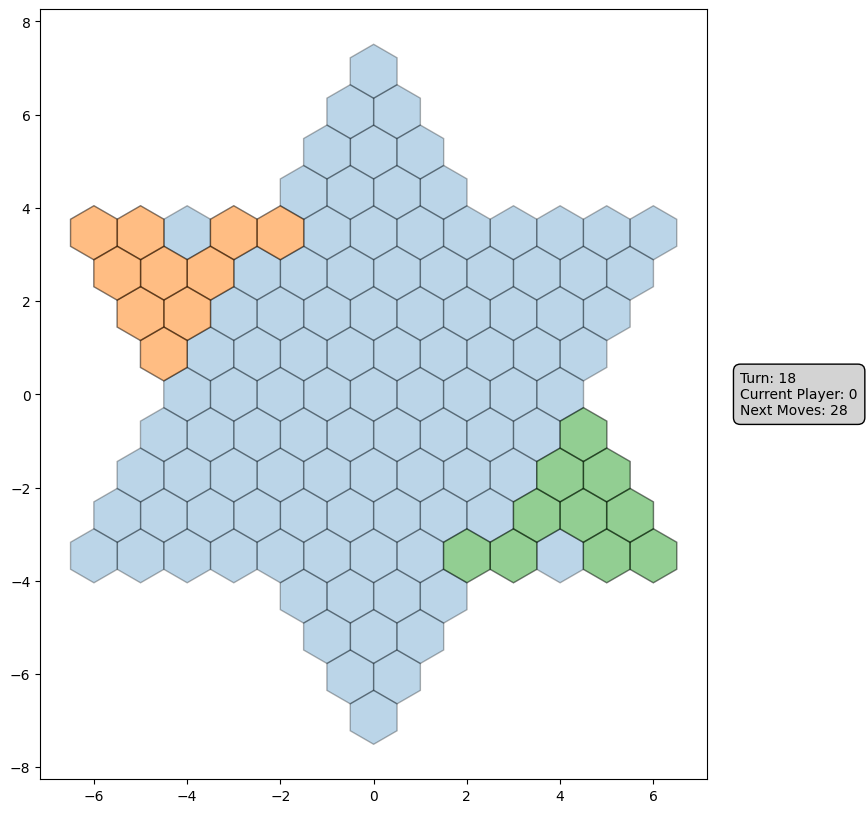

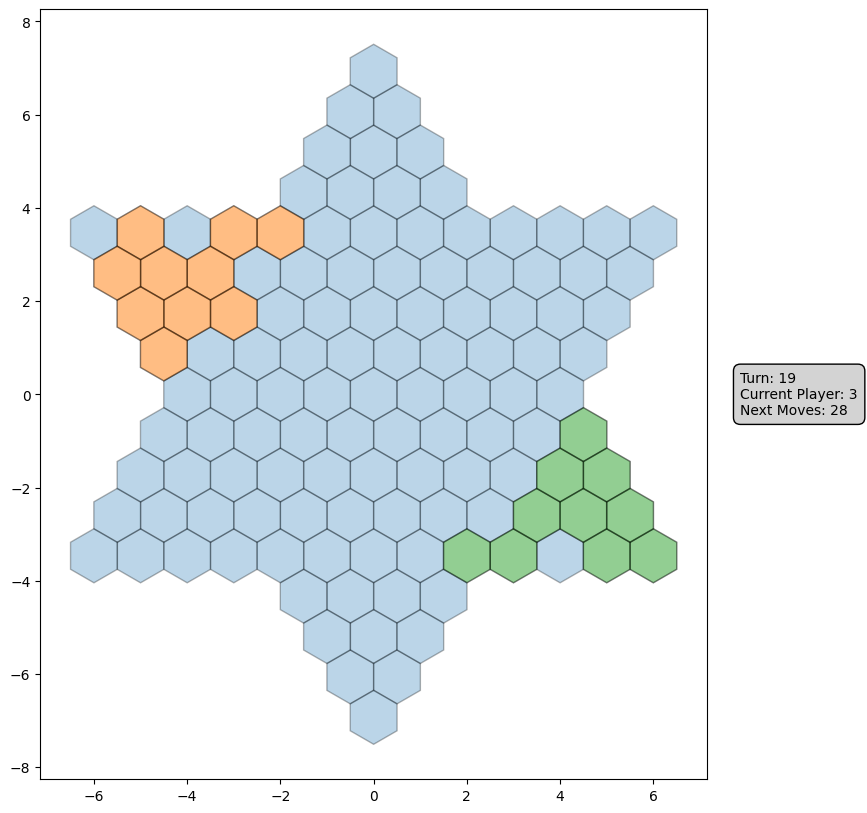

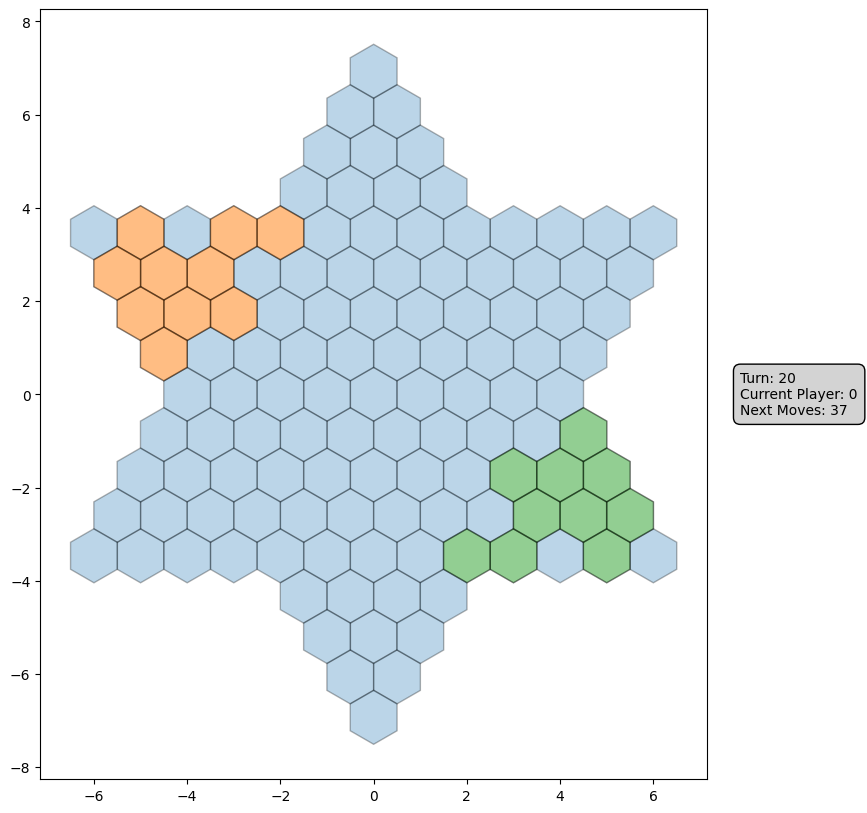

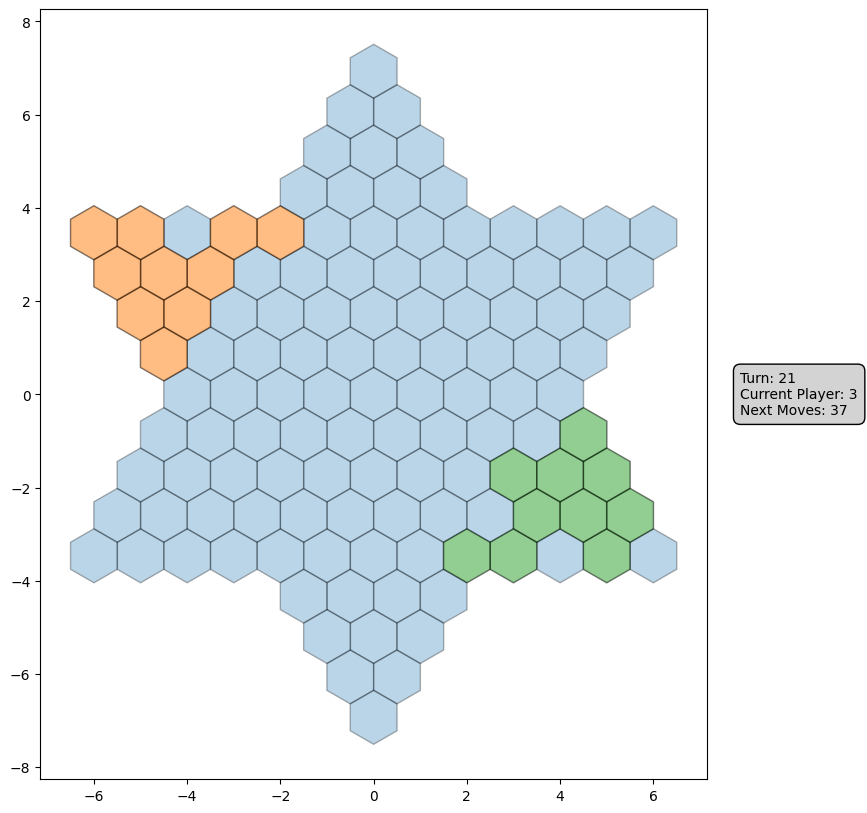

In [13]:
game_sequence = game_simulation._to_game_sequence()
for i, (move, game) in enumerate(zip(game_simulation.data.historical_moves, game_sequence)):
    print(f"\nCurrent Player: {game.get_current_player().player_id} \n{move}\nTurn: {i}")
    game.print()
    if i > 20:
        break